In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
print(PATH)

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
print(ROOT)


################################################################################
# electron signals
################################################################################
# electron signals
DATA = os.path.join(PATH, 'data_preproc/')

e_signals = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e.csv'), 
                        sep=';', index_col=0)

t = pd.read_csv(os.path.join(DATA, 'LightSignal_t.csv'), sep=';', index_col=0, 
                header=None)

t = np.array(t.iloc[0]).reshape(-1)

################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate = ["stepX", "dE", "PDGcode", "eventID", "E", 
                        'energydep', "energydepX", "energydepY", "energydepZ"]

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/data/sample_particles_v2/


In [2]:
################################################################################
# MAIN LOOP
################################################################################
skip = os.path.join(ROOT, ".DS_Store/")

idx, dE = [], []
energydepX, energydepY, energydepZ = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

ntree = 0
for folder in os.listdir(ROOT): 
    rel_PATH = os.path.join(ROOT, folder)
    rel_PATH += "/"
    
    if (rel_PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(rel_PATH):
        file = os.path.join(rel_PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate, library="np") 
            
            for entry in range(len(branches["eventID"])): # entries loop

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _, _, energydepX_e = etl.getElectron2EnergiesX0AndEnergydepx(
                #                                         branches["stepX"][entry], 
                #                                         branches["PDGcode"][entry],
                #                                         branches["dE"][entry],
                #                                         branches["E"][entry], 
                #                                         branches["energydepX"][entry]
                #                                         )
                
                dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry],
                                                     branches["PDGcode"][entry],
                                                     branches["dE"][entry])
                
                energydep_e, energydepX_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepX"][entry])
                
                _, energydepY_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepY"][entry])
                
                _, energydepZ_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepZ"][entry])
                
                idx.append(str(ntree)+'_'+str(entry+1))
                dE.append(dE_e) # MeV
                
                if len(energydepX_e)>0: 
                    weighted_mean = np.abs(np.average(energydepX_e, 
                                                      weights=energydep_e))
                    energydepX.append(weighted_mean)
                else: 
                    energydepX.append(0)
                    
                if len(energydepY_e)>0: 
                    weighted_mean = np.abs(np.average(energydepY_e, 
                                                      weights=energydep_e))
                    energydepY.append(weighted_mean)
                else: 
                    energydepY.append(0)
                    
                if len(energydepZ_e)>0: 
                    weighted_mean = np.abs(np.average(energydepZ_e, 
                                                      weights=energydep_e))
                    energydepZ.append(weighted_mean)
                else: 
                    energydepZ.append(0)
                
            
        # finish of file
        print(f'Time spent with tree {ntree}: {time()-mi} (s).')
        # print(np.shape(list_dE), np.shape(list_integrate))
        ntree+=1
        
print(f'Total time processing data: {(time()-m0)/60}(min).')

dE=pd.Series(dE, index=idx)
energydepX=pd.Series(energydepX, index=idx)
energydepY=pd.Series(energydepY, index=idx)
energydepZ=pd.Series(energydepZ, index=idx)

Time spent with tree 0: 0.13176703453063965 (s).
Time spent with tree 1: 0.14876508712768555 (s).
Time spent with tree 2: 0.15956807136535645 (s).
Time spent with tree 3: 0.1590409278869629 (s).
Time spent with tree 4: 0.16218328475952148 (s).
Time spent with tree 5: 0.16408896446228027 (s).
Time spent with tree 6: 0.14259696006774902 (s).
Time spent with tree 7: 0.14154863357543945 (s).
Time spent with tree 8: 0.1443309783935547 (s).
Time spent with tree 9: 0.1474301815032959 (s).
Time spent with tree 10: 0.14172005653381348 (s).
Time spent with tree 11: 0.21322202682495117 (s).
Time spent with tree 12: 0.13534879684448242 (s).
Time spent with tree 13: 0.13495802879333496 (s).
Time spent with tree 14: 0.1423048973083496 (s).
Time spent with tree 15: 0.13204121589660645 (s).
Time spent with tree 16: 0.13788199424743652 (s).
Time spent with tree 17: 0.14174890518188477 (s).
Time spent with tree 18: 0.13758325576782227 (s).
Time spent with tree 19: 0.1507110595703125 (s).
Time spent with

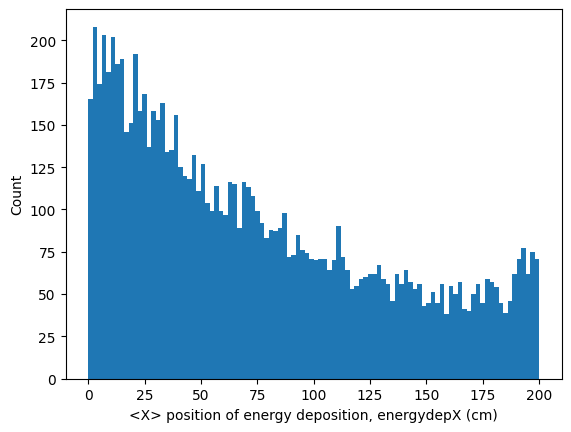

In [3]:
plt.hist(energydepX[energydepX>0], range=[0,200], bins=100)
plt.xlabel('<X> position of energy deposition, energydepX (cm)')
plt.ylabel('Count')
plt.show()

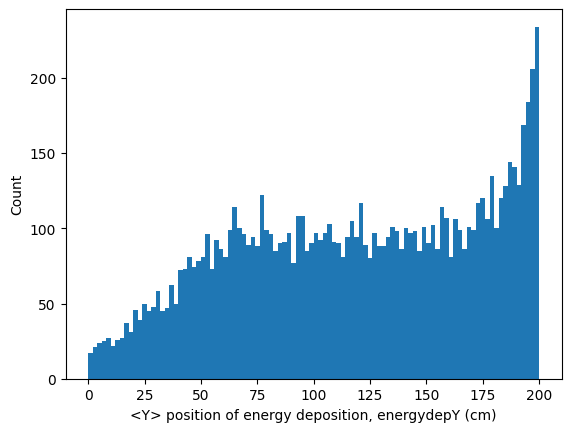

In [4]:
plt.hist(energydepY[energydepY>0], range=[0,200], bins=100)
plt.xlabel('<Y> position of energy deposition, energydepY (cm)')
plt.ylabel('Count')
plt.show()

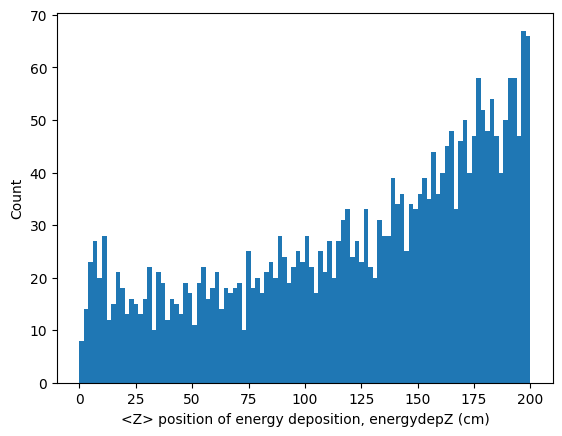

In [5]:
plt.hist(energydepZ[energydepZ>0], range=[0,200], bins=100)
plt.xlabel('<Z> position of energy deposition, energydepZ (cm)')
plt.ylabel('Count')
plt.show()

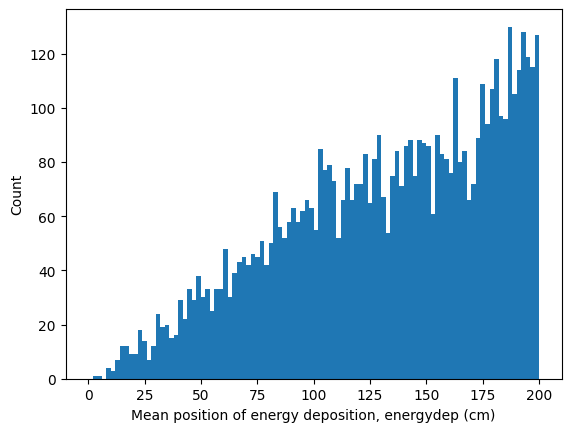

In [6]:
d = np.sqrt(np.square(energydepX[energydepX>0]) + 
            np.square(energydepY[energydepY>0]) +
            np.square(energydepX[energydepZ>0]))

plt.hist(d, range=[0,200], bins=100)
plt.xlabel('Mean position of energy deposition, energydep (cm)')
plt.ylabel('Count')
plt.show()

In [13]:
indexes = energydepX[energydepX>0].index
dE = dE.loc[indexes]
d = pd.Series(d, index=indexes)

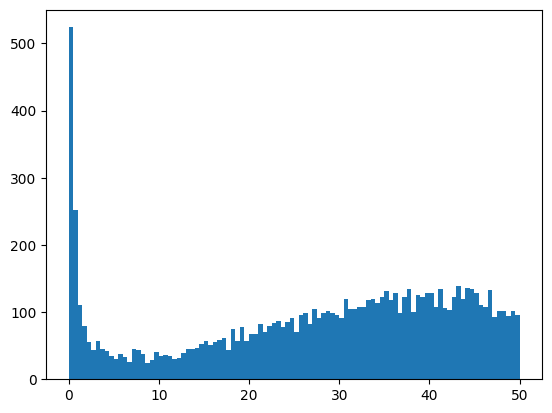

In [73]:
plt.hist(dE[dE>0], bins=100, range=[0,50])
plt.show()

In [14]:
integral_signal = []
for i in range(energydepX.shape[0]):
    integral_signal.append(np.trapz(e_signals.iloc[i,:], t))

integral_signal = pd.Series(integral_signal, index=idx)
integral_signal = integral_signal.loc[indexes]

[20, 11]


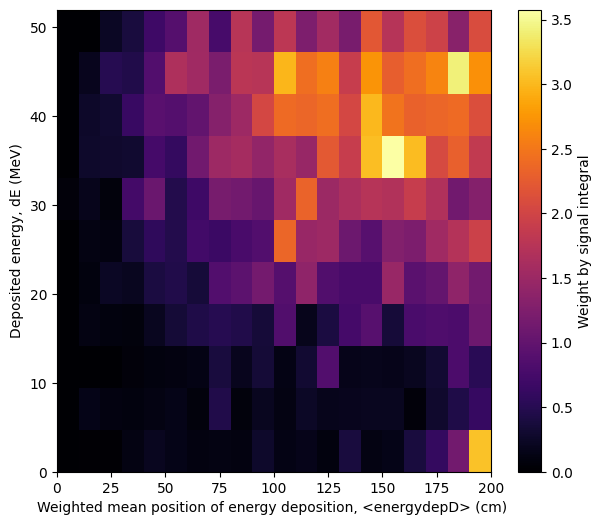

In [106]:
x = np.array(d)
y = np.array(dE)
z = np.array(integral_signal)
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

bins = [20, 11] # bins --> (width 10cm in dEX, X) and (width = 5MeV in dE, Y)
print(bins)
plt.figure(figsize=(7,6))
hist = plt.hist2d(x, y, weights=z_normalized, range=[[0,200], [0,52]], bins=bins, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Weight by signal integral') 

plt.xlabel('Weighted mean position of energy deposition, <energydepD> (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()

In [26]:
z_normalized[d<25].max()

0.13268676646285754

In [46]:
dE[d<25]

4_12       8.122183
9_28      19.471174
9_31      33.260577
22_6      39.283682
22_16     37.731648
            ...    
373_49    33.167951
377_10    20.839792
381_47    31.985368
393_22    25.020552
395_47    43.878715
Length: 85, dtype: float64

In [77]:
dE[dE<0.1]

19_22     0.049864
36_42     0.084581
40_42     0.037937
54_30     0.055634
54_45     0.093796
            ...   
377_43    0.070339
382_5     0.020390
386_1     0.095966
386_35    0.053441
399_28    0.086000
Length: 77, dtype: float64

In [82]:
z_normalized[d<105].shape

(1713,)

In [92]:
test = pd.DataFrame({'dE': dE, 'd': d}, index=indexes)
test[test['d']<25]

,dE,d
4_12,8.122183,22.443347
9_28,19.471174,24.822868
9_31,33.260577,18.076454
22_6,39.283682,19.701383
22_16,37.731648,19.628434
...,...,...
373_49,33.167951,24.718266
377_10,20.839792,12.629776
381_47,31.985368,15.415990
393_22,25.020552,16.846325
